In [1]:
import pandas as pd
import numpy as np
from time import time
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import nltk
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer


# Download necessary NLTK packages
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\filip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Extraction Features

In [2]:
df = pd.read_csv("processed_data/Resume_proc_lemm.csv")

In [3]:
# Get a list of stop word
stop_words = set(nltk.corpus.stopwords.words('english'))

In [4]:
tfidf_vect = TfidfVectorizer(
    lowercase=True,
    binary=False,
    max_features=10000,
    stop_words=list(stop_words),   # come prima, valuta se serve
    ngram_range=(1, 6),            # unigrams fino a 6-grams
    max_df=0.8,
    min_df=2
)

In [5]:
def extract_features(X_train, X_test):
    
    X_train_tfidf = tfidf_vect.fit_transform(X_train)
    X_test_tfidf = tfidf_vect.transform(X_test)

    return X_train_tfidf, X_test_tfidf

In [6]:
def smote(X_train, y_train):
    #print("Distribuzione delle classi nel training set prima di SMOTE:")
    # print(y_train.value_counts())
    
    # Identifica le classi minoritarie
    class_counts = y_train.value_counts()
    min_classes = class_counts[class_counts < 0.7*class_counts.mean()].index.tolist()
    
    print(f"Applicazione di SMOTE alle classi: {min_classes} \n")
    
    # Crea un dizionario per la strategia di campionamento
    target_size = int(class_counts.max() * 0.8)
    sampling_strategy = {cls: target_size for cls in min_classes}
    
    # Applica SMOTE
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # print("Distribuzione delle classi nel training set dopo SMOTE:")
    # print(pd.Series(y_train_resampled).value_counts())
    
    return X_train_resampled, y_train_resampled

In [7]:
# Split data into training and validation
X_train, X_test, y_train, y_test = train_test_split(df['Resume_str'], df['Category'], test_size=0.2, random_state=42, stratify=df['Category'])


# Print the sizes of the split datasets
print("Train data size:", X_train.shape)
print("Validation data size:", X_test.shape)

Train data size: (1986,)
Validation data size: (497,)


In [8]:
X_train_features, X_test_features = extract_features(X_train, X_test)

In [9]:
X_train_resampled, y_train_resampled = smote(X_train_features, y_train)

Applicazione di SMOTE alle classi: ['AGRICULTURE', 'AUTOMOBILE', 'BPO'] 



In [10]:
len(tfidf_vect.vocabulary_)

10000

### Random Forest Classifier

In [11]:
def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print(f"Model with rank: {i}")
            print(f"Mean validation score: f{results['mean_test_score'][candidate]:.3f} (std: {results['std_test_score'][candidate]:.3f})")
            print(f"Parameters: {results['params'][candidate]}")
            print("")

In [12]:
skf = StratifiedKFold(n_splits=5)

In [13]:
'''
RFC = RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [100, 300, 700],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [6,7,8,9,10],
    'criterion' :['gini', 'entropy']
}

grid = GridSearchCV(estimator=RFC, param_grid=param_grid, cv= skf, scoring='accuracy', return_train_score=False, verbose=3)

start = time()
grid_search = grid.fit(X_train_resampled, y_train_resampled)

print(f"GridSearchCV took {(time() - start):.2f} seconds for {len(grid_search.cv_results_['params'])} candidates parameter settings.\n")
report(grid_search.cv_results_) '''

'\nRFC = RandomForestClassifier(random_state=42)\n\nparam_grid = { \n    \'n_estimators\': [100, 300, 700],\n    \'max_features\': [\'sqrt\', \'log2\'],\n    \'max_depth\' : [6,7,8,9,10],\n    \'criterion\' :[\'gini\', \'entropy\']\n}\n\ngrid = GridSearchCV(estimator=RFC, param_grid=param_grid, cv= skf, scoring=\'accuracy\', return_train_score=False, verbose=3)\n\nstart = time()\ngrid_search = grid.fit(X_train_resampled, y_train_resampled)\n\nprint(f"GridSearchCV took {(time() - start):.2f} seconds for {len(grid_search.cv_results_[\'params\'])} candidates parameter settings.\n")\nreport(grid_search.cv_results_) '

In [14]:
# print(grid_search.best_params_)

In [15]:
'''
results = pd.DataFrame(grid_search.cv_results_)

filtered = results[
    (results['param_criterion'] == 'gini') & 
    (results['param_max_features'] == 'sqrt')
]

pvt = filtered.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_n_estimators'
)

import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(pvt, cmap='viridis', annot=True, ax=ax)
plt.title('Accuracy Score (criterion=gini, max_features=sqrt)')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.show() 
'''

"\nresults = pd.DataFrame(grid_search.cv_results_)\n\nfiltered = results[\n    (results['param_criterion'] == 'gini') & \n    (results['param_max_features'] == 'sqrt')\n]\n\npvt = filtered.pivot_table(\n    values='mean_test_score',\n    index='param_max_depth',\n    columns='param_n_estimators'\n)\n\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\nf, ax = plt.subplots(figsize=(6, 5))\nsns.heatmap(pvt, cmap='viridis', annot=True, ax=ax)\nplt.title('Accuracy Score (criterion=gini, max_features=sqrt)')\nplt.xlabel('n_estimators')\nplt.ylabel('max_depth')\nplt.show() \n"

In [16]:
# best_model = grid_search.best_estimator_
# prediction = best_model.predict(X_test_features)

In [17]:
RF_Model_best = RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators= 700, max_depth=10, criterion='gini')
RF_Model_best.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=10, n_estimators=700, random_state=42)

In [18]:
prediction = RF_Model_best.predict(X_test_features)

In [19]:

print(classification_report(y_test,prediction))

                        precision    recall  f1-score   support

            ACCOUNTANT       0.62      1.00      0.76        24
              ADVOCATE       0.90      0.75      0.82        24
           AGRICULTURE       1.00      0.46      0.63        13
               APPAREL       1.00      0.37      0.54        19
                  ARTS       1.00      0.10      0.17        21
            AUTOMOBILE       1.00      0.29      0.44         7
              AVIATION       0.85      0.92      0.88        24
               BANKING       0.81      0.57      0.67        23
                   BPO       0.75      0.75      0.75         4
  BUSINESS-DEVELOPMENT       0.92      0.92      0.92        24
                  CHEF       0.83      0.83      0.83        24
          CONSTRUCTION       0.83      0.86      0.84        22
            CONSULTANT       0.83      0.65      0.73        23
              DESIGNER       0.91      1.00      0.95        21
         DIGITAL-MEDIA       0.93      

In [20]:
print("Training Score: {:.2f}".format(RF_Model_best.score(X_train_resampled, y_train_resampled)))
print("Test Score: {:.2f}".format(RF_Model_best.score(X_test_features, y_test)))

Training Score: 0.95
Test Score: 0.75


<Figure size 1500x1000 with 0 Axes>

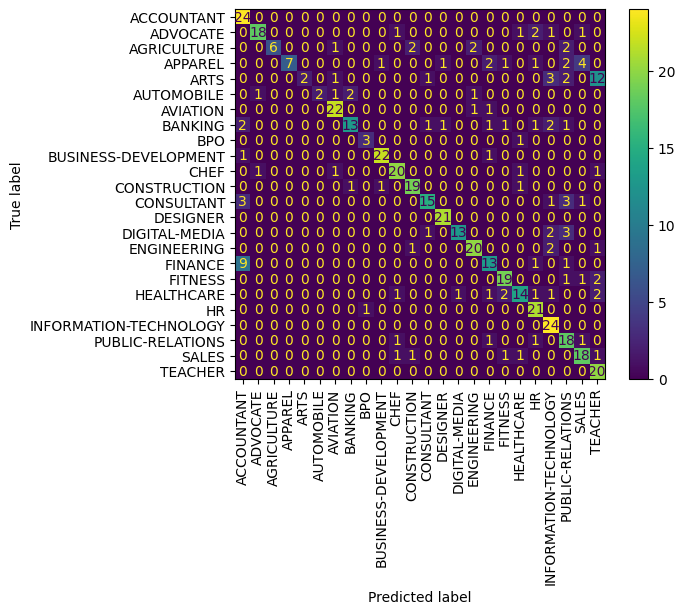

In [21]:
plt.figure(figsize=(15, 10))  # Imposta la dimensione della figura
ConfusionMatrixDisplay.from_predictions(y_test, prediction)
plt.xticks(rotation=90)
plt.show()

### Analisi Overfitting

<Figure size 1500x1000 with 0 Axes>

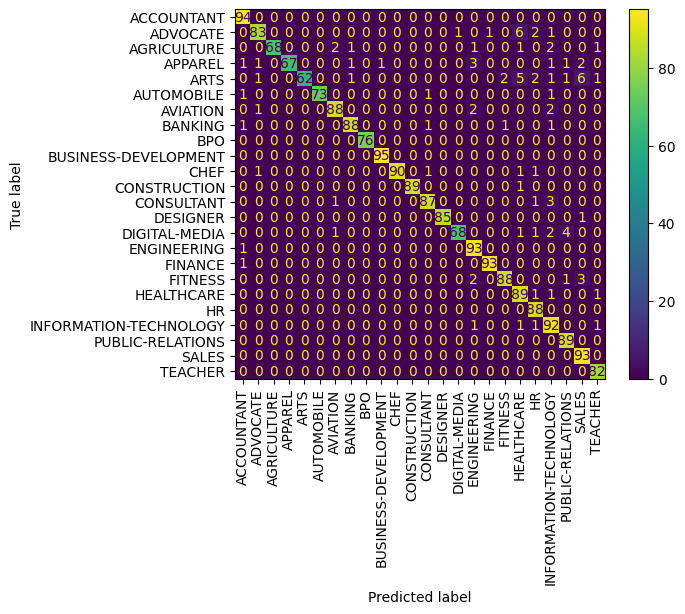

In [22]:
prediction_train = RF_Model_best.predict(X_train_resampled)

plt.figure(figsize=(15, 10))  # Imposta la dimensione della figura
ConfusionMatrixDisplay.from_predictions(y_train_resampled, prediction_train)
plt.xticks(rotation=90)
plt.show()

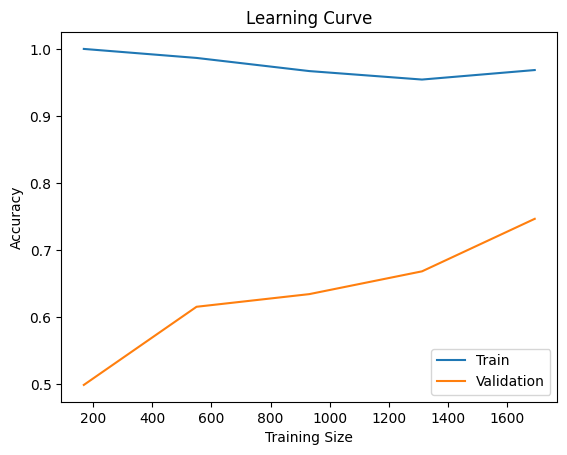

In [23]:
train_sizes, train_scores, test_scores = learning_curve(
    RF_Model_best, X_train_resampled, y_train_resampled, cv=skf, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Train')
plt.plot(train_sizes, test_mean, label='Validation')
plt.legend()
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.show()


### Altro Modello per diminuire overfitting

In [24]:
RF_Model = RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators= 500, max_depth=6, criterion='gini')
RF_Model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=6, n_estimators=500, random_state=42)

In [25]:
prediction = RF_Model.predict(X_test_features)

In [26]:
print(classification_report(y_test,prediction))

                        precision    recall  f1-score   support

            ACCOUNTANT       0.57      1.00      0.73        24
              ADVOCATE       0.81      0.71      0.76        24
           AGRICULTURE       1.00      0.46      0.63        13
               APPAREL       1.00      0.32      0.48        19
                  ARTS       0.00      0.00      0.00        21
            AUTOMOBILE       1.00      0.29      0.44         7
              AVIATION       0.80      0.83      0.82        24
               BANKING       0.85      0.48      0.61        23
                   BPO       1.00      0.25      0.40         4
  BUSINESS-DEVELOPMENT       0.96      0.92      0.94        24
                  CHEF       0.80      0.83      0.82        24
          CONSTRUCTION       0.83      0.91      0.87        22
            CONSULTANT       0.83      0.65      0.73        23
              DESIGNER       0.84      1.00      0.91        21
         DIGITAL-MEDIA       0.89      

c:\Users\filip\anaconda3\envs\DMML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\filip\anaconda3\envs\DMML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\filip\anaconda3\envs\DMML\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1500x1000 with 0 Axes>

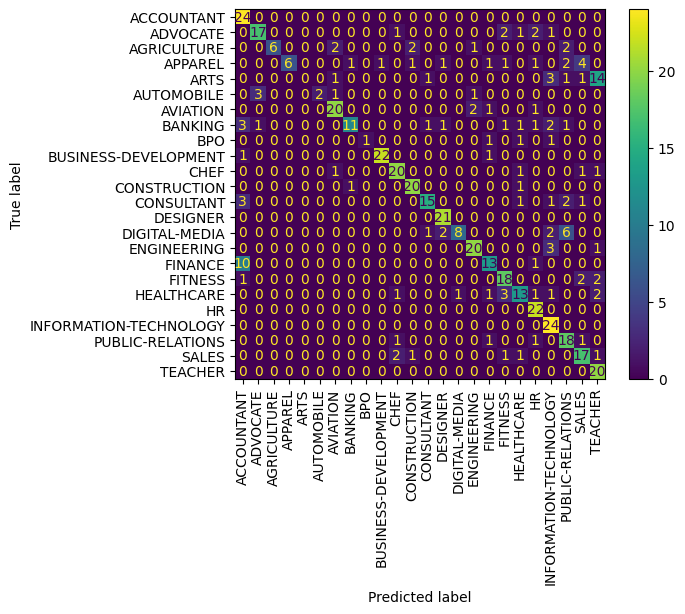

In [27]:
prediction_train = RF_Model.predict(X_test_features)

plt.figure(figsize=(15, 10))  # Imposta la dimensione della figura
ConfusionMatrixDisplay.from_predictions(y_test, prediction_train)
plt.xticks(rotation=90)
plt.show()